In [1]:
import numpy as np
from scipy.special import hankel2
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, RickerSource, Receiver, TimeAxis, AcquisitionGeometry
from devito import set_log_level
from benchmarks.user.tools.plotter import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
# Switch to error logging so that info is printed but runtime is hidden
from devito import configuration
configuration['log-level'] = 'ERROR'

In [3]:
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1

# Verification

We compute the error between the numerical and reference solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the error for these parameters.

In [4]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)

In [5]:
# Number of time steps
nt = 1501
# Time axis
dt = 0.1
t0 = 0.
tn = dt * (nt-1)
time = np.linspace(t0, tn, nt)
print("t0, tn, dt, nt; %.4f %.4f %.4f %d" % (t0, tn, dt, nt))
# Source peak frequency in KHz
f0 = .09

t0, tn, dt, nt; 0.0000 150.0000 0.1000 1501


In [6]:
# Domain sizes and gird spacing
shapes = ((201, 2.0), (161, 2.5), (101, 4.0))
dx = [2.0, 2.5, 4.0]
nshapes = len(shapes)

In [7]:
# Fine grid model
c0 = 1.5
model = ModelBench(vp=c0, origin=(0., 0.), spacing=(.5, .5), 
                   shape=(801, 801), space_order=20, nbl=40, dtype=np.float64)

In [8]:
# Source and receiver geometries
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = 200.

# Single receiver offset 100 m from source
rec_coordinates = np.empty((1, 2))
rec_coordinates[:, :] = 260.

print("The computational Grid has (%s, %s) grid points "
       "and a physical extent of (%sm, %sm)" % (*model.grid.shape, *model.grid.extent))
print("Source is at the center with coordinates (%sm, %sm)" % tuple(src_coordinates[0]))
print("Receiver (single receiver) is located at (%sm, %sm) " %  tuple(rec_coordinates[0]))
    
# Note: gets time sampling from model.critical_dt
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                               t0=t0, tn=tn, src_type='Ricker', f0=f0, t0w=1.5/f0)

The computational Grid has (881, 881) grid points and a physical extent of (440.0m, 440.0m)
Source is at the center with coordinates (200.0m, 200.0m)
Receiver (single receiver) is located at (260.0m, 260.0m) 


# Reference solution for numerical convergence

In [9]:
solver = AcousticWaveSolver(model, geometry, kernel='OT2', space_order=8)
ref_rec, ref_u, _ = solver.forward()

# Analytical solution for comparison with the reference numerical solution

The analytical solution of the 2D acoustic wave-equation with a source pulse is defined as:

$$
u_s(r, t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \{ -i \pi H_0^{(2)}\left(k r \right) q(\omega) e^{i\omega t} d\omega\}
$$

$$
r = \sqrt{(x - x_{src})^2+(y - y_{src})^2}
$$

where $H_0^{(2)}$ is the Hankel function of the second kind, $F(\omega)$ is the Fourier spectrum of the source time function at angular frequencies $\omega$ and $k = \frac{\omega}{v}$ is the wavenumber.

We look at the analytical and numerical solution at a single grid point. We ensure that this grid point is on-the-grid for all discretizations analyised in the further verification.

In [10]:
# Source and receiver coordinates
sx, sz = src_coordinates[0, :]
rx, rz = rec_coordinates[0, :]

# Define a Ricker wavelet shifted to zero lag for the Fourier transform
def ricker(f, T, dt, t0):
    t = np.linspace(-t0, T-t0, int(T/dt))
    tt = (np.pi**2) * (f**2) * (t**2)
    y = (1.0 - 2.0 * tt) * np.exp(- tt)
    return y

def analytical(nt, model, time, **kwargs):
    dt = kwargs.get('dt', model.critical_dt)
    # Fourier constants
    nf = int(nt/2 + 1)
    fnyq = 1. / (2 * dt)
    df = 1.0 / time[-1]
    faxis = df * np.arange(nf)

    wavelet = ricker(f0, time[-1], dt, 1.5/f0)

    # Take the Fourier transform of the source time-function
    R = np.fft.fft(wavelet)
    R = R[0:nf]
    nf = len(R)

    # Compute the Hankel function and multiply by the source spectrum
    U_a = np.zeros((nf), dtype=complex)
    for a in range(1, nf-1):
        k = 2 * np.pi * faxis[a] / c0
        tmp = k * np.sqrt(((rx - sx))**2 + ((rz - sz))**2)
        U_a[a] = -1j * np.pi * hankel2(0.0, tmp) * R[a]

    # Do inverse fft on 0:dt:T and you have analytical solution
    U_t = 1.0/(2.0 * np.pi) * np.real(np.fft.ifft(U_a[:], nt))
    
    # The analytic solution needs be scaled by dx^2 to convert to pressure
    return np.real(U_t) * (model.spacing[0]**2)

In [11]:
time1 = np.linspace(0.0, 3000., 30001)
U_t = analytical(30001, model, time1, dt=time1[1] - time1[0])
U_t = U_t[0:1501]

In [12]:
print("Numerical data min,max,abs; %+12.6e %+12.6e %+12.6e" % 
      (np.min(ref_rec.data), np.max(ref_rec.data), np.max(np.abs(ref_rec.data)) ))
print("Analytic  data min,max,abs; %+12.6e %+12.6e %+12.6e" % 
      (np.min(U_t), np.max(U_t), (np.max(np.abs(U_t)))))

Numerical data min,max,abs; -5.349877e-03 +8.529867e-03 +8.529867e-03
Analytic  data min,max,abs; -5.322232e-03 +8.543911e-03 +8.543911e-03


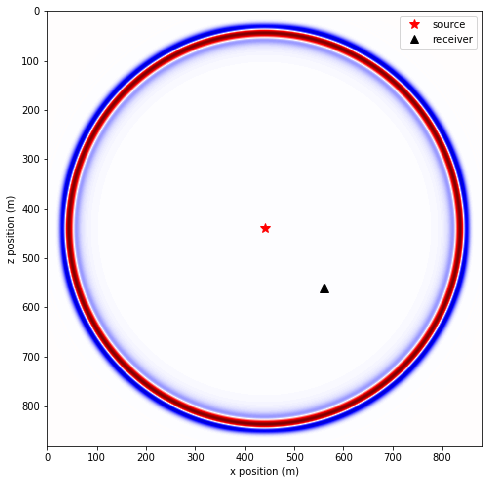

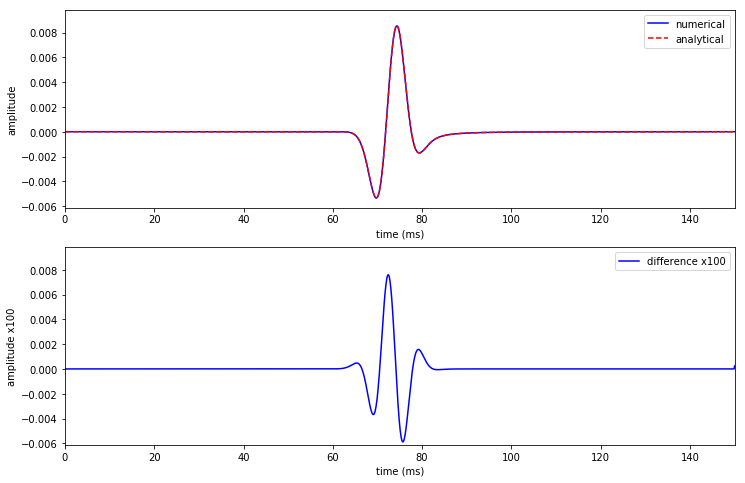

In [13]:
# Plot wavefield and source/rec position
plt.figure(figsize=(8,8))
amax = np.max(np.abs(ref_u.data[1,:,:]))
plt.imshow(ref_u.data[1,:,:], vmin=-1.0 * amax, vmax=+1.0 * amax, cmap="seismic")
plt.plot(2*sx+40, 2*sz+40, 'r*', markersize=11, label='source')   # plot position of the source in model, add nbl for correct position
plt.plot(2*rx+40, 2*rz+40, 'k^', markersize=8, label='receiver')  # plot position of the receiver in model, add nbl for correct position
plt.legend()
plt.xlabel('x position (m)')
plt.ylabel('z position (m)')
plt.savefig('wavefieldperf.pdf')

# Plot trace
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(time, ref_rec.data[:, 0], '-b', label='numerical')
plt.plot(time, U_t[:], '--r', label='analytical')
plt.xlim([0,150])
plt.ylim([1.15*np.min(U_t[:]), 1.15*np.max(U_t[:])])
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()
plt.subplot(2,1,2)
plt.plot(time, 100 *(ref_rec.data[:, 0] - U_t[:]), '-b', label='difference x100')
plt.xlim([0,150])
plt.ylim([1.15*np.min(U_t[:]), 1.15*np.max(U_t[:])])
plt.xlabel('time (ms)')
plt.ylabel('amplitude x100')
plt.legend()
plt.savefig('ref.pdf')
plt.show()

In [14]:
#NBVAL_IGNORE_OUTPUT
error_time = np.zeros(5)
error_time[0] = np.linalg.norm(U_t[:-1] - ref_rec.data[:-1, 0], 2) / np.sqrt(nt)
errors_plot = [(time, U_t[:-1] - ref_rec.data[:-1, 0])]
print(error_time[0])

1.1265077536665097e-05


# Convergence in time


We first show the convergence of the time discretization for a fix high-order spatial discretization (20th order).

After we show that the time discretization converges in $O(dt^2)$ and therefore only contains the error in time, we will take the numerical solution for `dt=.1ms` as a reference for the spatial discretization analysis.



In [15]:
#NBVAL_IGNORE_OUTPUT
dt = [0.1000, 0.0800, 0.0750, 0.0625, 0.0500]
nnt = (np.divide(150.0, dt) + 1).astype(int)

for i in range(1, 5):
    # Time axis
    t0 = 0.0
    tn = 150.0
    time = np.linspace(t0, tn, nnt[i])

    # Source geometry
    src_coordinates = np.empty((1, 2))
    src_coordinates[0, :] = 200.

    # Single receiver offset 100 m from source
    rec_coordinates = np.empty((1, 2))
    rec_coordinates[:, :] = 260.

    geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                                   t0=t0, tn=tn, src_type='Ricker', f0=f0, t0w=1.5/f0)

    # Note: incorrect data size will be generated here due to AcquisitionGeometry bug ... 
    # temporarily fixed below by resizing the output from the solver
    geometry.resample(dt[i])
    print("geometry.time_axes; ", geometry.time_axis)
    
    solver = AcousticWaveSolver(model, geometry, time_order=2, space_order=8)
    ref_rec1, ref_u1, _ = solver.forward(dt=dt[i])
    ref_rec1_data = ref_rec1.data[0:nnt[i],:]

    time1 = np.linspace(0.0, 3000., 20*(nnt[i]-1) + 1)
    U_t1 = analytical(20*(nnt[i]-1) + 1, model, time1, dt=time1[1] - time1[0])
    U_t1 = U_t1[0:nnt[i]]

    error_time[i] = np.linalg.norm(U_t1[:-1] - ref_rec1_data[:-1, 0], 2) / np.sqrt(nnt[i]-1)

    ratio_d = dt[i-1]/dt[i] if i > 0 else 1.0
    ratio_e = error_time[i-1]/error_time[i] if i > 0 else 1.0
    print("error for dt=%.4f is %12.6e -- ratio dt^2,ratio err; %12.6f %12.6f \n" % 
          (dt[i], error_time[i], ratio_d**2, ratio_e))
    errors_plot.append((geometry.time_axis.time_values, U_t1[:-1] - ref_rec1_data[:-1, 0]))

geometry.time_axes;  TimeAxis: start=0, stop=150.08, step=0.08, num=1877
error for dt=0.0800 is 7.419952e-06 -- ratio dt^2,ratio err;     1.562500     1.518214 

geometry.time_axes;  TimeAxis: start=0, stop=150, step=0.075, num=2001
error for dt=0.0750 is 6.582594e-06 -- ratio dt^2,ratio err;     1.137778     1.127208 

geometry.time_axes;  TimeAxis: start=0, stop=150, step=0.0625, num=2401
error for dt=0.0625 is 4.707689e-06 -- ratio dt^2,ratio err;     1.440000     1.398264 

geometry.time_axes;  TimeAxis: start=0, stop=150, step=0.05, num=3001
error for dt=0.0500 is 3.144849e-06 -- ratio dt^2,ratio err;     1.562500     1.496952 



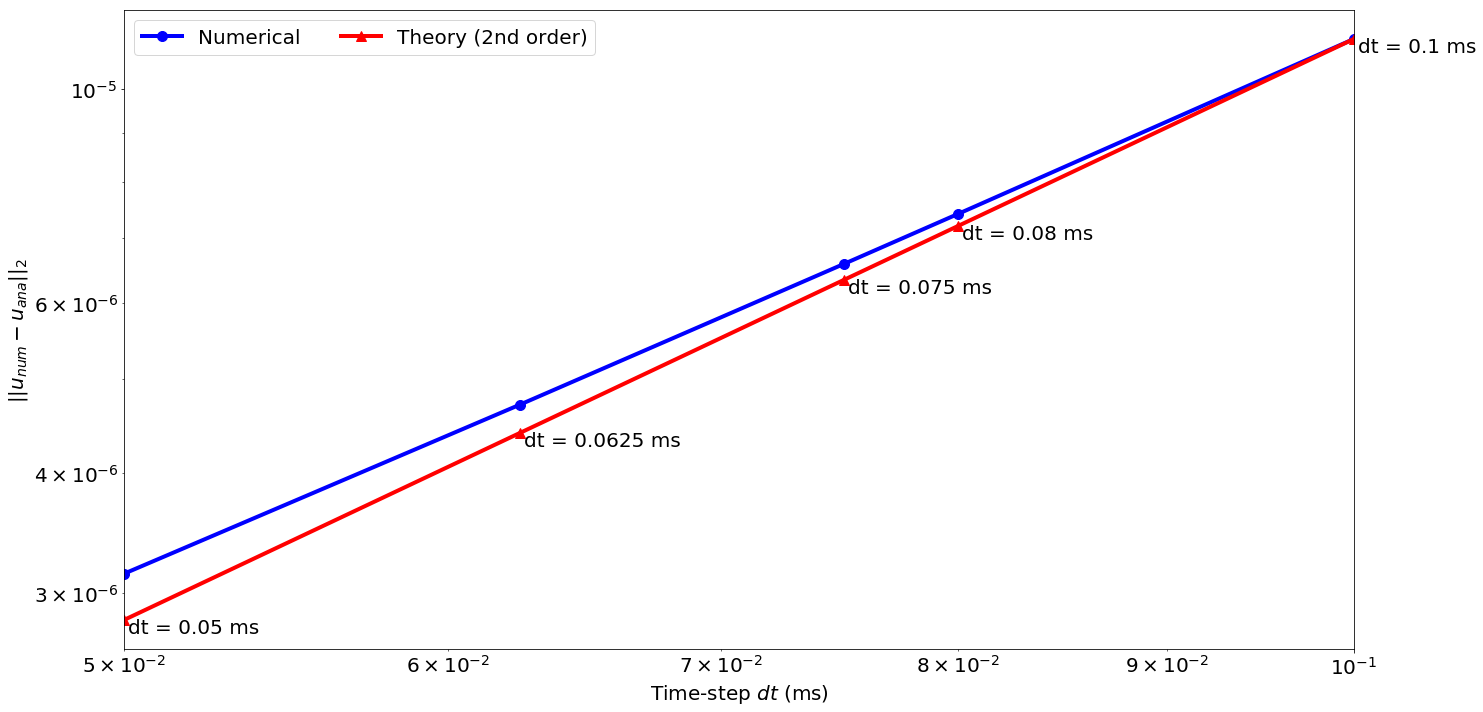

In [16]:
plt.figure(figsize=(20, 10))
theory = [t**2 for t in dt]
theory = [error_time[0]*th/theory[0] for th in theory]
plt.loglog([t for t in dt], error_time, '-ob', label=('Numerical'), linewidth=4, markersize=10)
plt.loglog([t for t in dt], theory, '-^r', label=('Theory (2nd order)'), linewidth=4, markersize=10)
for x, y, a in zip([t for t in dt], theory, [('dt = %s ms' % (t)) for t in dt]):
            plt.annotate(a, xy=(x, y), xytext=(4, 2),
                         textcoords='offset points', size=20,
                         horizontalalignment='left', verticalalignment='top')
plt.xlabel("Time-step $dt$ (ms)", fontsize=20)
plt.ylabel("$|| u_{num} - u_{ana}||_2$", fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.xlim((0.05, 0.1))
plt.legend(fontsize=20, ncol=4, fancybox=True, loc='best')
plt.savefig("TimeConvergence.pdf", format='pdf', facecolor='white',
            orientation='landscape', bbox_inches='tight')
plt.show()

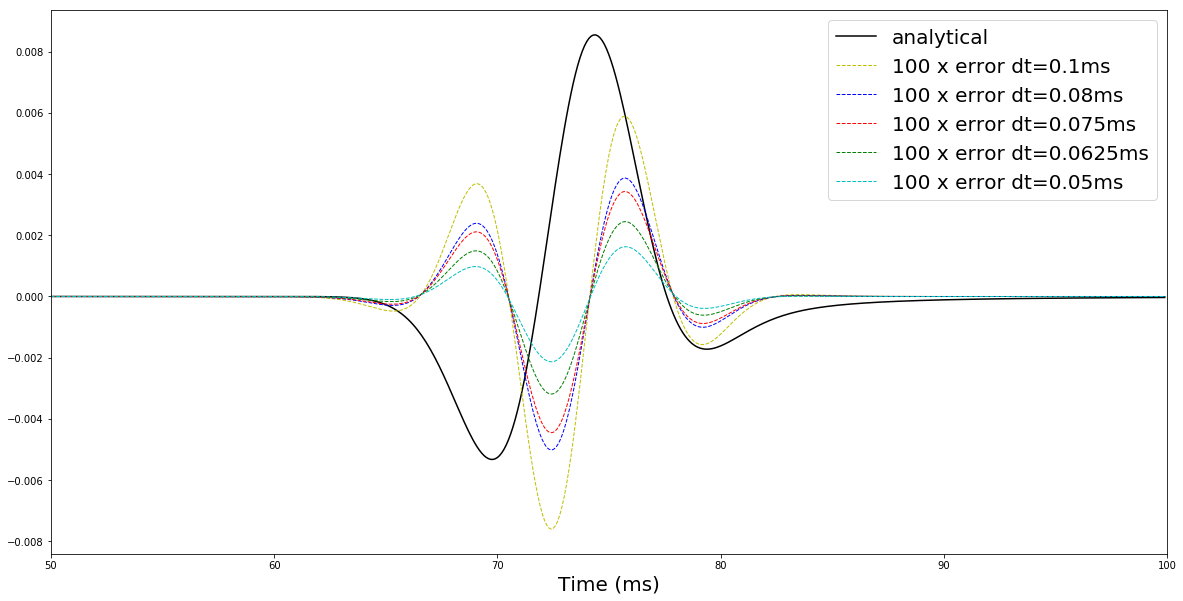

In [17]:
#NBVAL_IGNORE_OUTPUT
stylel = ('--y', '--b', '--r', '--g', '--c')

start_t = lambda dt: int(50/dt)
end_t = lambda dt: int(100/dt)


plt.figure(figsize=(20, 10))

for i, dti in enumerate(dt):
    timei, erri = errors_plot[i]
    s, e = start_t(dti), end_t(dti)
    if i == 0:
        plt.plot(timei[s:e], U_t[s:e], 'k', label='analytical')
    plt.plot(timei[s:e], 100*erri[s:e], stylel[i], label="100 x error dt=%sms"%dti, linewidth=1)
plt.xlim([50,100])
plt.xlabel("Time (ms)", fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [18]:
pf = np.polyfit(np.log([t for t in dt]), np.log(error_time), deg=1)
print("Convergence rate in time is: %.4f" % pf[0])
assert np.isclose(pf[0], 1.9, atol=0, rtol=.1)

Convergence rate in time is: 1.8403


# Convergence in space
We have a correct reference solution we can use for space discretization analysis

In [19]:
#NBVAL_IGNORE_OUTPUT
errorl2 = np.zeros((norder, nshapes))
timing = np.zeros((norder, nshapes))

set_log_level("ERROR")
ind_o = -1
for spc in orders:
    ind_o +=1
    ind_spc = -1
    for nn, h in shapes:
        ind_spc += 1
        time = np.linspace(0., 150., nt)

        model_space = ModelBench(vp=c0, origin=(0., 0.), spacing=(h, h), 
                           shape=(nn, nn), space_order=spc, nbl=40, dtype=np.float64)

        # Source geometry
        src_coordinates = np.empty((1, 2))
        src_coordinates[0, :] = 200.

        # Single receiver offset 100 m from source
        rec_coordinates = np.empty((1, 2))
        rec_coordinates[:, :] = 260.

        geometry = AcquisitionGeometry(model_space, rec_coordinates, src_coordinates, 
                                       t0=t0, tn=tn, src_type='Ricker', f0=f0, t0w=1.5/f0)

        solver = AcousticWaveSolver(model_space, geometry, time_order=2, space_order=spc)
        loc_rec, loc_u, summary = solver.forward()

        # Note: we need to correct for fixed spacing pressure corrections in both analytic  
        # (run at the old model spacing) and numerical (run at the new model spacing) solutions
        c_ana = 1 / model.spacing[0]**2
        c_num = 1 / model_space.spacing[0]**2

        # Compare to reference solution
        # Note: we need to normalize by the factor of grid spacing squared 
        errorl2[ind_o, ind_spc] = np.linalg.norm(loc_rec.data[:-1, 0] * c_num - U_t[:-1] * c_ana, 2) / np.sqrt(U_t.shape[0] - 1)
        timing[ind_o, ind_spc] = np.max([v for _, v in summary.timings.items()])
        print("starting space order %s with (%s, %s) grid points the error is %s for %s seconds runtime" %
              (spc, nn, nn, errorl2[ind_o, ind_spc], timing[ind_o, ind_spc]))

starting space order 2 with (201, 201) grid points the error is 0.003768757089983623 for 0.1748060000000012 seconds runtime
starting space order 2 with (161, 161) grid points the error is 0.0058129254529761835 for 0.21149200000000104 seconds runtime
starting space order 2 with (101, 101) grid points the error is 0.013011694999129065 for 0.07801899999999973 seconds runtime
starting space order 4 with (201, 201) grid points the error is 0.00034026936091496667 for 0.37839800000000073 seconds runtime
starting space order 4 with (161, 161) grid points the error is 0.0009417088269800824 for 0.24217000000000008 seconds runtime
starting space order 4 with (101, 101) grid points the error is 0.006347209638329639 for 0.07040300000000002 seconds runtime
starting space order 6 with (201, 201) grid points the error is 4.51214308487045e-05 for 0.21069699999999686 seconds runtime
starting space order 6 with (161, 161) grid points the error is 0.00020690570060743783 for 0.1496300000000023 seconds runt

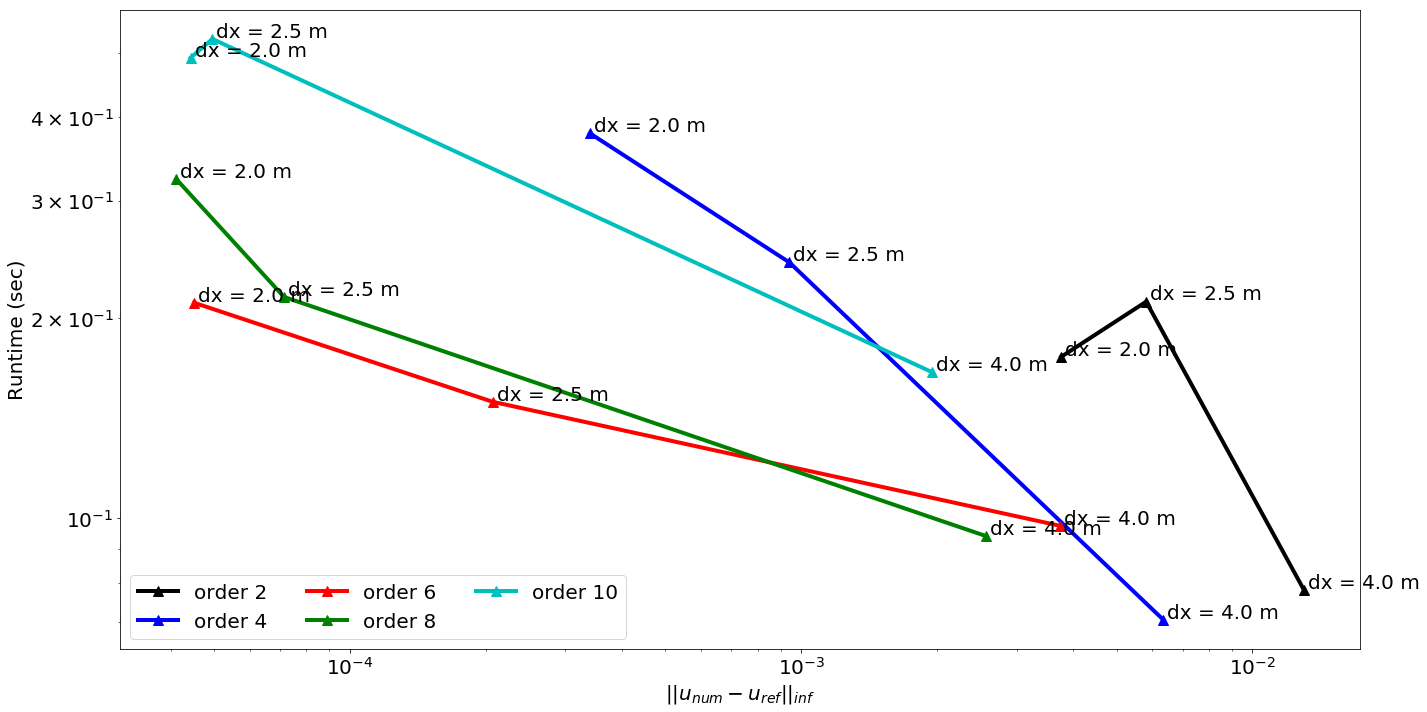

In [20]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

plt.figure(figsize=(20, 10))
for i in range(0, 5):
    plt.loglog(errorl2[i, :], timing[i, :], stylel[i], label=('order %s' % orders[i]), linewidth=4, markersize=10)
    for x, y, a in zip(errorl2[i, :], timing[i, :], [('dx = %s m' % (sc)) for sc in dx]):
                plt.annotate(a, xy=(x, y), xytext=(4, 2),
                             textcoords='offset points', size=20)
plt.xlabel("$|| u_{num} - u_{ref}||_{inf}$", fontsize=20)
plt.ylabel("Runtime (sec)", fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.legend(fontsize=20, ncol=3, fancybox=True, loc='lower left')
plt.savefig("TimeAccuracy.pdf", format='pdf', facecolor='white',
            orientation='landscape', bbox_inches='tight')
plt.show()

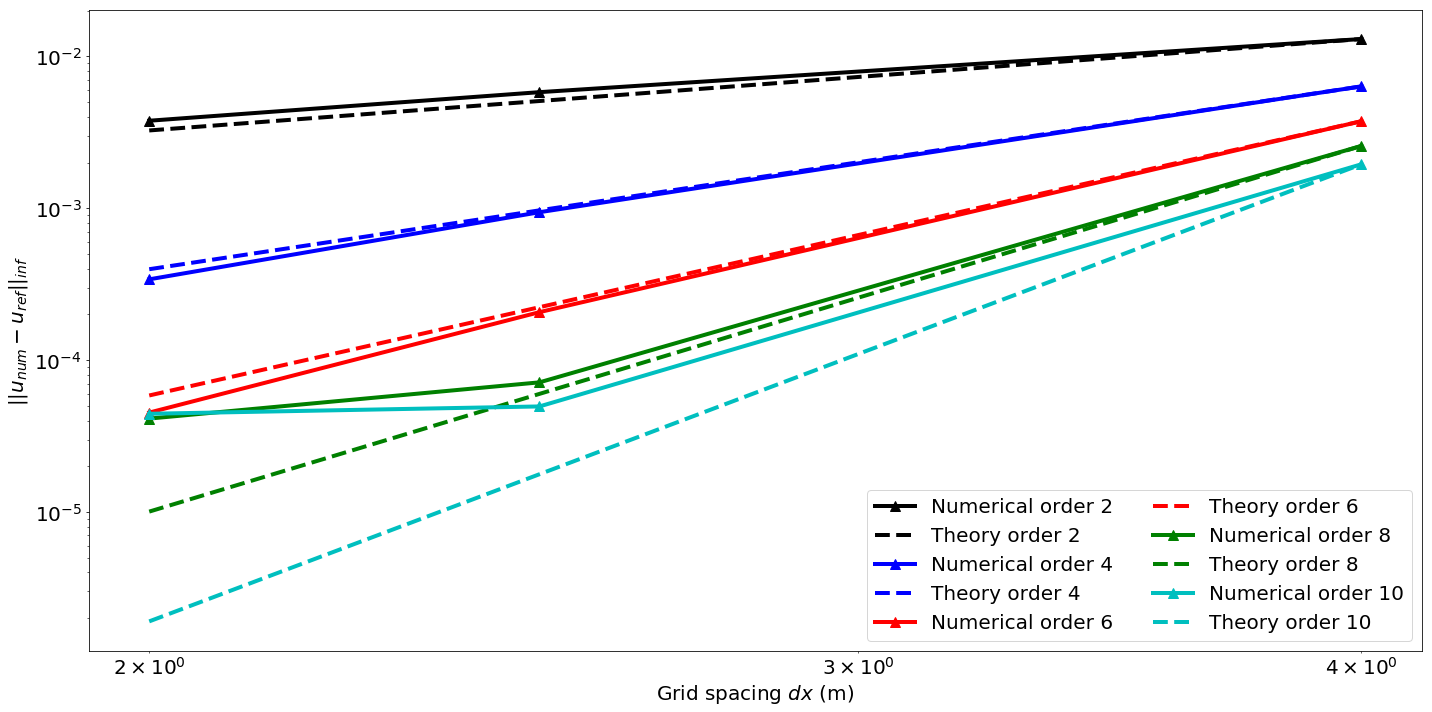

In [21]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

plt.figure(figsize=(20, 10))
for i in range(0, 5):
    theory = [k**(orders[i]) for k in dx]
    theory = [errorl2[i, 2]*th/theory[2] for th in theory]
    plt.loglog([sc for sc in dx], errorl2[i, :], stylel[i], label=('Numerical order %s' % orders[i]),
               linewidth=4, markersize=10)
    plt.loglog([sc for sc in dx], theory, style2[i], label=('Theory order %s' % orders[i]),
               linewidth=4, markersize=10)
plt.xlabel("Grid spacing $dx$ (m)", fontsize=20)
plt.ylabel("$||u_{num} - u_{ref}||_{inf}$", fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.legend(fontsize=20, ncol=2, fancybox=True, loc='lower right')
# plt.xlim((2.0, 4.0))
plt.savefig("Convergence.pdf", format='pdf', facecolor='white',
            orientation='landscape', bbox_inches='tight')
plt.show()

In [22]:
#NBVAL_IGNORE_OUTPUT
for i in range(5):
    pf = np.polyfit(np.log([sc for sc in dx]), np.log(errorl2[i, :]), deg=1)[0]
    if i==3:
        pf = np.polyfit(np.log([sc for sc in dx][1:]), np.log(errorl2[i, 1:]), deg=1)[0]
    print("Convergence rate for order %s is %s" % (orders[i], pf))
    if i<4:
        assert np.isclose(pf, orders[i], atol=0, rtol=.2)

Convergence rate for order 2 is 1.776330865071686
Convergence rate for order 4 is 4.196400949442503
Convergence rate for order 6 is 6.341221318071003
Convergence rate for order 8 is 7.628065332059304
Convergence rate for order 10 is 5.82224411146033
